In [1]:
import os
# image helper functions
def get_image_file_path(image_file_name):
    """returns the path of image file"""
    return './open_images/' + image_file_name

def get_images(n):
    """reads all the files from `./open_images/` directory and returns paths for n files from top"""
    all_image_files = os.listdir("./open_images/")
    # let's save all these image paths for later
    image_paths = list(map(get_image_file_path, all_image_files))
    # rather than using all, we will use a subset of these image paths for working on our model
    image_paths = image_paths[:n]
    return image_paths

def get_image_id_from_path(image_path):
    """returns image id from image path"""
    return image_path.split('./open_images/')[1].split('.jpg')[0]

In [2]:
# quick sanity check
P=get_images(10)
print(get_images(10))
print(get_image_id_from_path(get_images(1)[0]))

['./open_images/24b4c703fb0563eb.jpg', './open_images/006ed813bf26b40d.jpg', './open_images/86654567acf66f1c.jpg', './open_images/4a8a314f669db2ed.jpg', './open_images/73d76f76e3071234.jpg', './open_images/baa8805e186d590f.jpg', './open_images/9edf3e1ba0cd8a29.jpg', './open_images/f5d4d2b2935559ea.jpg', './open_images/b11f7209ccc0ae0b.jpg', './open_images/4291e7da3587ff7c.jpg']
24b4c703fb0563eb


In [3]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('./open_images/9edf3e1ba0cd8a29.jpg')
img1 = Image.open('./open_images/4291e7da3587ff7c.jpg')
imgplot = plt.imshow(img)
imgplot2 = plt.imshow(img1)

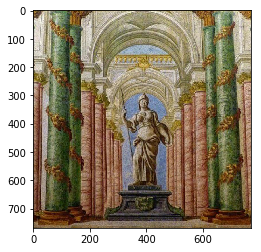

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in P:
        #plt.subplot(len(P))
        #mpimg.imread(i)
        plt.imshow(mpimg.imread(i))
#plt.show()        

In [5]:
# submission helper functions
def get_prediction_string(result):
    with tf.device('/device:GPU:0'):
        """from each result, generates the complete prediction string in the format {Label Confidence XMin YMin XMax YMax},{...} based on submission file."""
        prediction_strings = []
        for index, score in enumerate(result['detection_scores']):
            index = int(index)
            single_prediction_string = ""
            single_prediction_string += result['detection_class_names'][index].decode("utf-8") + " "  + str(score) + " "
            single_prediction_string += " ".join(str(x) for x in result['detection_boxes'][index])
            prediction_strings.append(single_prediction_string)

        prediction_string = " ".join(str(x) for x in prediction_strings)
        return prediction_string

def get_prediction_entry(filepath, result):
    return {
        "ImageID": get_image_id_from_path(filepath),
        "PredictionString": get_prediction_string(result)
    }

In [6]:
import tensorflow as tf
#os.environ["TFHUB_CACHE_DIR"] = '/tmp/tfhub'
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
from six import BytesIO

# For drawing onto the image.
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
cpu_config = tf.ConfigProto(intra_op_parallelism_threads = 20,
                                        inter_op_parallelism_threads = 20,
                                        device_count = {'CPU': 20})
sess = tf.Session(config=cpu_config)
# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: 


In [7]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

In [8]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
            25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [9]:
#module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
module_path = os.path.join('.','fastrcnn')
image_path = "./open_images/00000b4dcff7f799.jpg"

with tf.device('/device:GPU:0'):
    with tf.Graph().as_default():
        detector = hub.Module(module_path)
        image_string_placeholder = tf.placeholder(tf.string)
        decoded_image = tf.image.decode_jpeg(image_string_placeholder)
        # Module accepts as input tensors of shape [1, height, width, 3], i.e. batch
        # of size 1 and type tf.float32.
        decoded_image_float = tf.image.convert_image_dtype(
            image=decoded_image, dtype=tf.float32)
        module_input = tf.expand_dims(decoded_image_float, 0)
        result = detector(module_input, as_dict=True)
        init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]

        session = tf.Session()
        session.run(init_ops)

        # Load the downloaded and resized image and feed into the graph.
        with tf.gfile.Open(image_path, "rb") as binfile:
            image_string = binfile.read()

        result_out, image_out = session.run(
            [result, decoded_image],
            feed_dict={image_string_placeholder: image_string})
        print("Found %d objects." % len(result_out["detection_scores"]))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0804 16:29:57.123808 47573181952128 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0804 16:30:25.159991 47573181952128 saver.py:1483] Saver not created because there are no variables in the graph to restore


Found 100 objects.


Font not found, using default font.


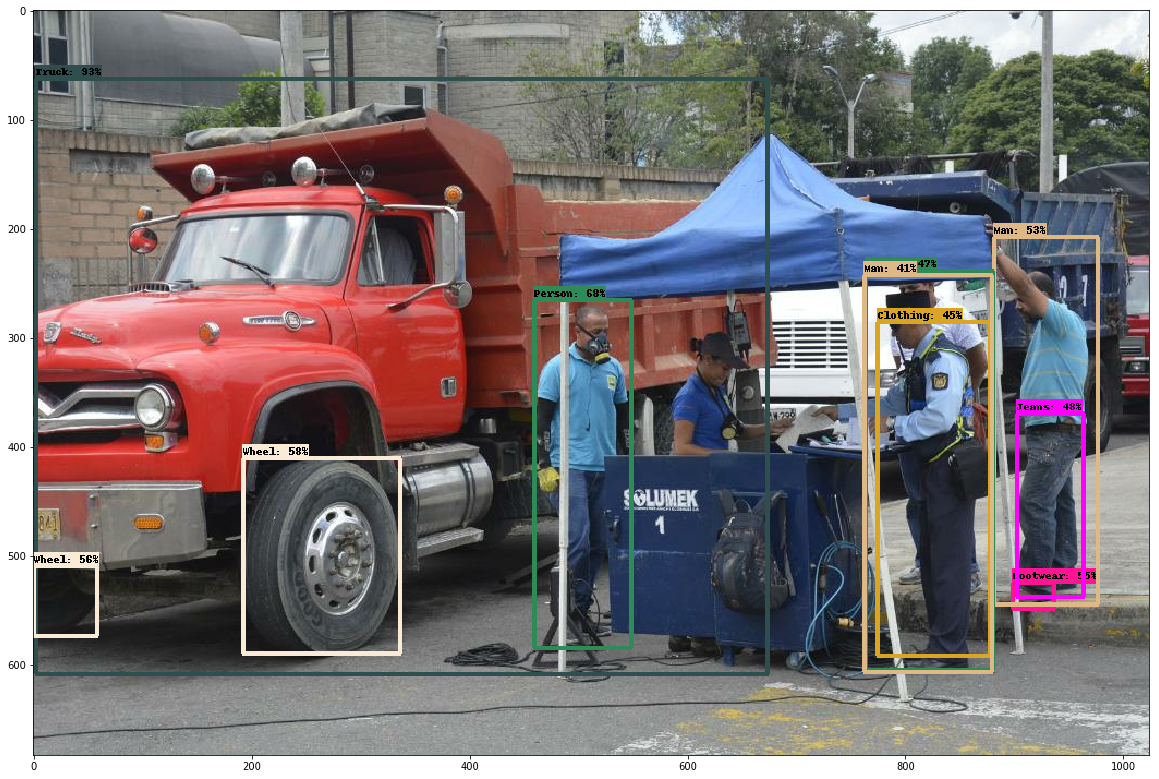

In [10]:
# see the sample image with bounding boxes
image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])
display_image(image_with_boxes)

In [11]:
image_paths = get_images(500)
predictions = []

with tf.device('/device:GPU:0'):
    for image_path in image_paths:
        with tf.gfile.Open(image_path, "rb") as binfile:
            image_string = binfile.read()

        inference_start_time = time.clock()
        result_out, image_out = session.run(
            [result, decoded_image],
            feed_dict={image_string_placeholder: image_string})
        predictions.append(get_prediction_entry(image_path, result_out))
        print(f'For {image_path} found objects in {time.clock() - inference_start_time} seconds')

For ./open_images/24b4c703fb0563eb.jpg found objects in 165.82000000000005 seconds
For ./open_images/006ed813bf26b40d.jpg found objects in 155.57999999999993 seconds
For ./open_images/86654567acf66f1c.jpg found objects in 155.5200000000001 seconds
For ./open_images/4a8a314f669db2ed.jpg found objects in 165.38999999999987 seconds
For ./open_images/73d76f76e3071234.jpg found objects in 170.56000000000017 seconds
For ./open_images/baa8805e186d590f.jpg found objects in 148.51999999999998 seconds
For ./open_images/9edf3e1ba0cd8a29.jpg found objects in 166.01999999999998 seconds
For ./open_images/f5d4d2b2935559ea.jpg found objects in 161.6199999999999 seconds
For ./open_images/b11f7209ccc0ae0b.jpg found objects in 204.33000000000015 seconds
For ./open_images/4291e7da3587ff7c.jpg found objects in 179.02999999999975 seconds
For ./open_images/ed333c406c545b26.jpg found objects in 202.62000000000035 seconds
For ./open_images/68e35c1ff4369943.jpg found objects in 213.28999999999996 seconds
For ./

In [12]:
predictions_df = pd.DataFrame(predictions)
predictions_df

,ImageID,PredictionString
0,24b4c703fb0563eb,/m/07j7r 0.7843414 0.0004412969 0.014015991 0....
1,006ed813bf26b40d,/m/0cgh4 0.95697045 0.0 0.0 0.96468395 0.96264...
2,86654567acf66f1c,/m/01mzpv 0.9316985 0.45064995 0.046346452 0.9...
3,4a8a314f669db2ed,/m/09j2d 0.7413264 0.4792035 0.50462824 0.6088...
4,73d76f76e3071234,/m/01d40f 0.8906419 0.49163836 0.34594655 0.96...
5,baa8805e186d590f,/m/02wbm 0.75873727 0.24426319 0.67599034 0.31...
6,9edf3e1ba0cd8a29,/m/07j7r 0.8438189 0.2570424 0.0015916221 0.45...
7,f5d4d2b2935559ea,/m/01fdzj 0.14729366 0.15401062 0.38488793 0.8...
8,b11f7209ccc0ae0b,/m/04yx4 0.8939805 0.021952108 0.0016981373 0....
9,4291e7da3587ff7c,/m/0cgh4 0.7245621 0.0 0.0 1.0 1.0 /m/06msq 0....


In [17]:
!chmod 644 sample_submission.csv

In [18]:
submission_df = pd.read_csv(r'sample_submission.csv')
submission_df.update(predictions_df)

In [19]:
submission_df.to_csv('500_values_submission.csv', index=False)